In [34]:
!pip install biopython
!pip install logomaker


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from collections import Counter
from PIL import Image
import pickle

from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    log_loss,
    balanced_accuracy_score,
    matthews_corrcoef,
    cohen_kappa_score,
    multilabel_confusion_matrix
)

from Bio.Seq import Seq
from Bio import Align
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment

import logomaker
from wordcloud import WordCloud
%matplotlib inline

In [36]:
url='https://archive.ics.uci.edu/ml/machine-learning-databases/molecular-biology/promoter-gene-sequences/promoters.data'
names=["class","id","sequence"]
df=pd.read_csv(url,names=names)

In [37]:
df.head()

,class,id,sequence
0,+,S10,\t\ttactagcaatacgcttgcgttcggtggttaagtatgtataat...
1,+,AMPC,\t\ttgctatcctgacagttgtcacgctgattggtgtcgttacaat...
2,+,AROH,\t\tgtactagagaactagtgcattagcttatttttttgttatcat...
3,+,DEOP2,\taattgtgatgtgtatcgaagtgtgttgcggagtagatgttagaa...
4,+,LEU1_TRNA,\ttcgataattaactattgacgaaaagctgaaaaccactagaatgc...


In [38]:
df.shape

(106, 3)

In [39]:
df.isnull().sum()

class       0
id          0
sequence    0
dtype: int64

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   class     106 non-null    object
 1   id        106 non-null    object
 2   sequence  106 non-null    object
dtypes: object(3)
memory usage: 2.6+ KB


# Class Distribution (Bar Plot)

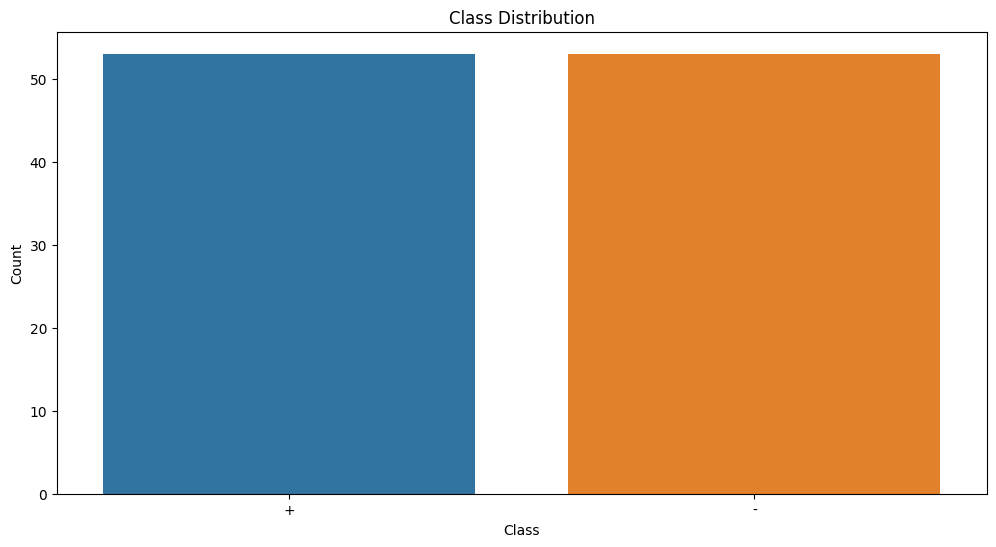

In [41]:
plt.figure(figsize=(12, 6))
sns.countplot(x='class', data=df)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Sequence Length Distribution (Histogram)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


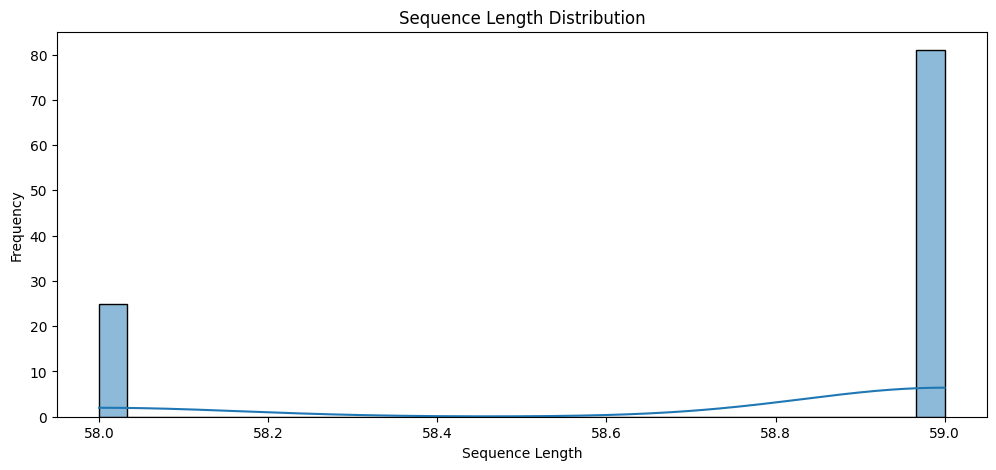

In [42]:
df['seq_length'] = df['sequence'].str.len()
plt.figure(figsize=(12, 5))
sns.histplot(df['seq_length'], bins=30, kde=True)
plt.title('Sequence Length Distribution')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

# Nucleotide Composition (Stacked Bar Plot)

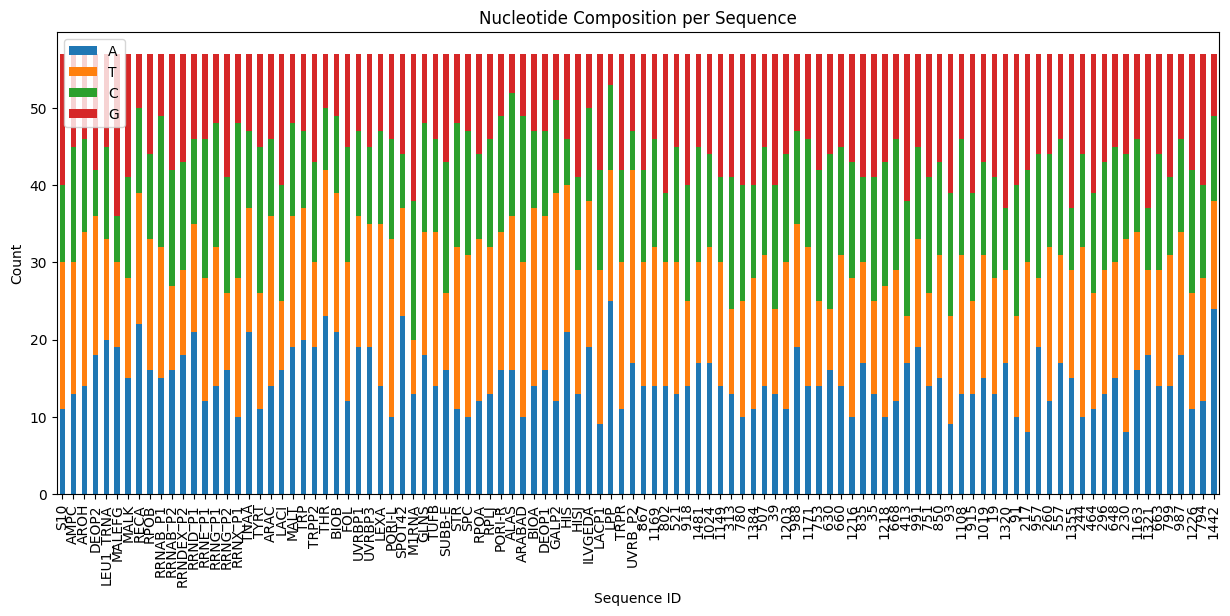

In [43]:
nucleotide_counts = pd.DataFrame({
    'id': df['id'],
    'A': df['sequence'].apply(lambda x: x.count('a')),
    'T': df['sequence'].apply(lambda x: x.count('t')),
    'C': df['sequence'].apply(lambda x: x.count('c')),
    'G': df['sequence'].apply(lambda x: x.count('g'))
})
nucleotide_counts.set_index('id').plot(kind='bar', stacked=True, figsize=(15, 6))
plt.title('Nucleotide Composition per Sequence')
plt.xlabel('Sequence ID')
plt.ylabel('Count')
plt.show()

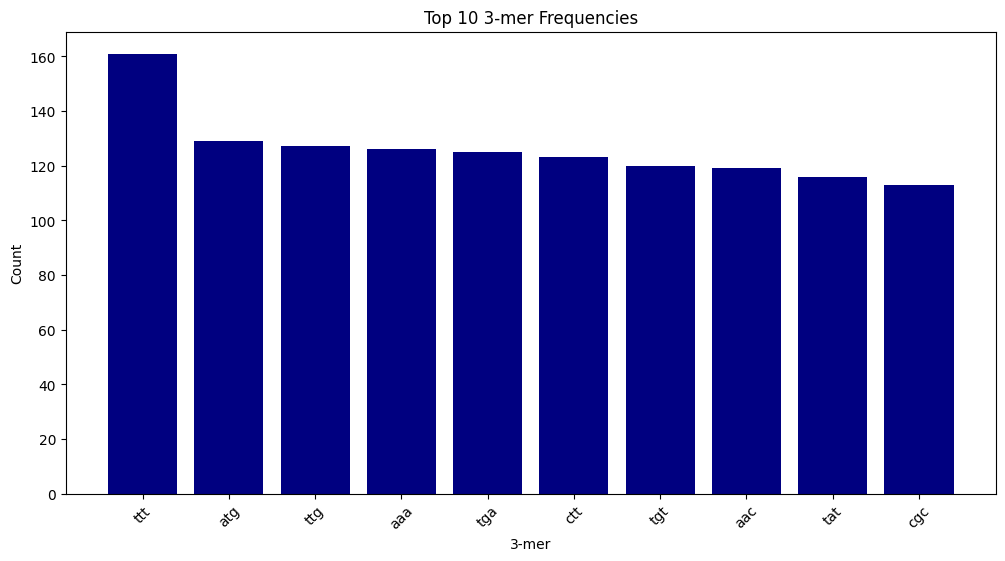

In [44]:
df['sequence'] = df['sequence'].str.replace('\t', '')
aligner = Align.PairwiseAligner()
records = [SeqRecord(Seq(seq), id=ID) for seq, ID in zip(df['sequence'], df['id'])]
alignments = MultipleSeqAlignment(records)  # Simplified, assumes pre-aligned
with open('alignment.txt', 'w') as f:
    f.write(str(alignments))

# 5. K-mer Frequency (Bar Plot for 3-mers)
def get_kmers(sequence, k=3):
    return [sequence[i:i+k] for i in range(len(sequence)-k+1)]
all_kmers = []
for seq in df['sequence']:
    all_kmers.extend(get_kmers(seq, k=3))
kmer_counts = Counter(all_kmers)
top_kmers = dict(sorted(kmer_counts.items(), key=lambda x: x[1], reverse=True)[:10])
plt.figure(figsize=(12, 6))
plt.bar(top_kmers.keys(), top_kmers.values(),color="navy")
plt.title('Top 10 3-mer Frequencies')
plt.xlabel('3-mer')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

#  GC Content (Bar Plot)

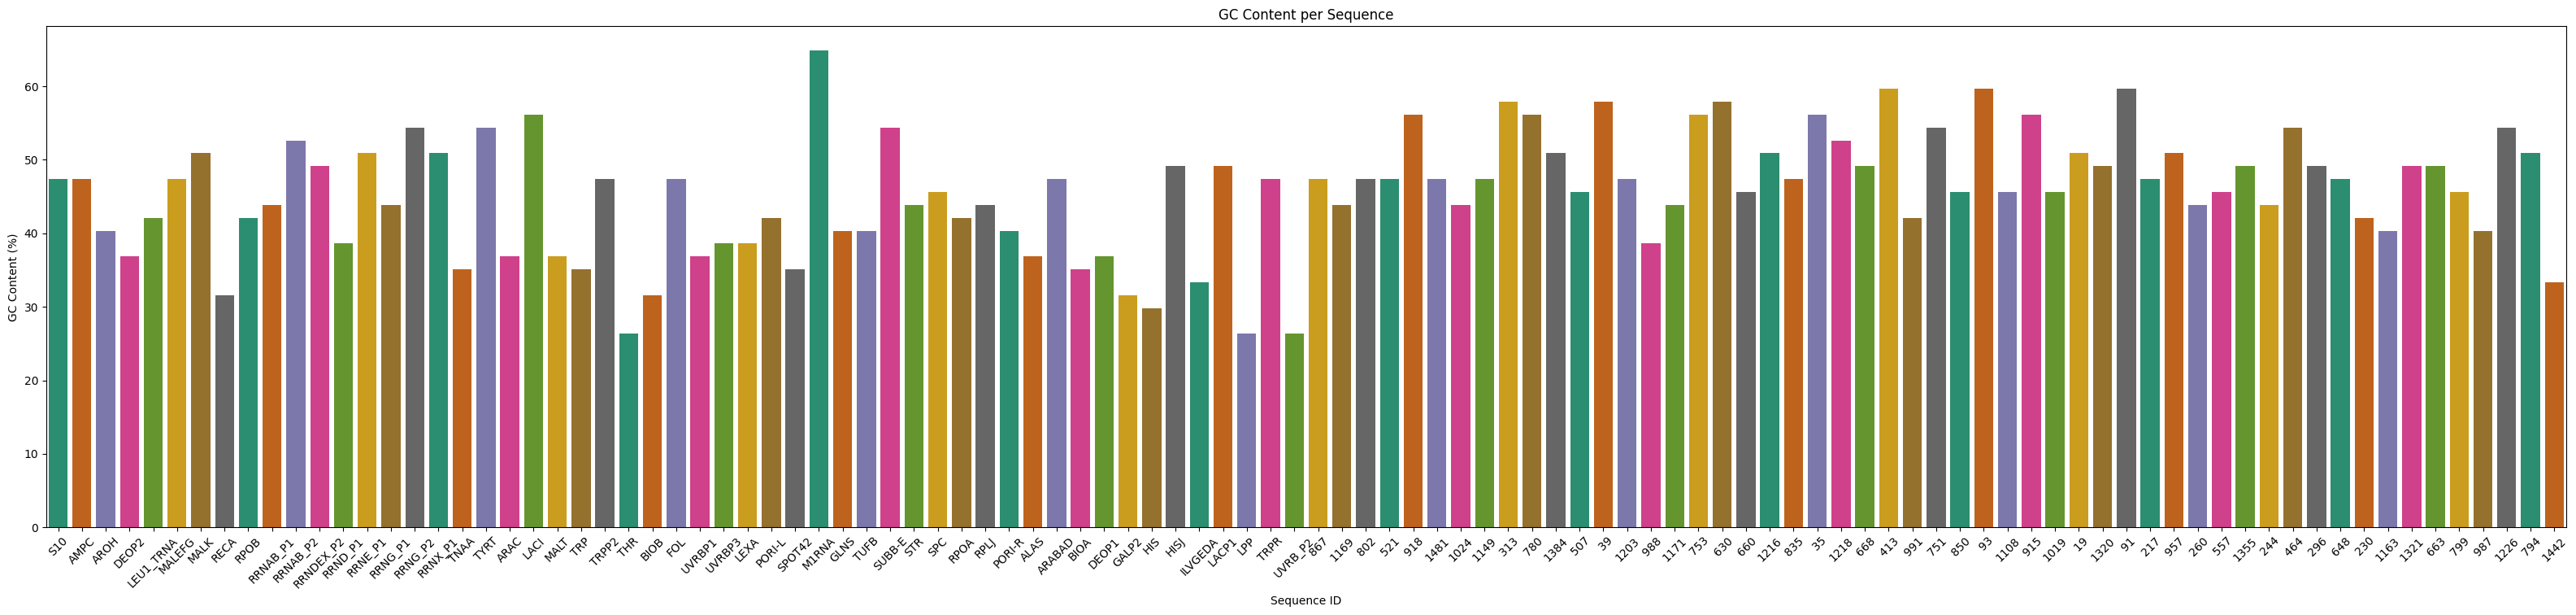

In [45]:
df['gc_content'] = df['sequence'].apply(lambda x: (x.count('g') + x.count('c')) / len(x) * 100)
plt.figure(figsize=(40, 8))
sns.barplot(x='id', y='gc_content', data=df,palette="Dark2")
plt.title('GC Content per Sequence')
plt.xlabel('Sequence ID')
plt.ylabel('GC Content (%)')
plt.xticks(rotation=45)
plt.show()

# Sequence Logo (Using Logomaker)

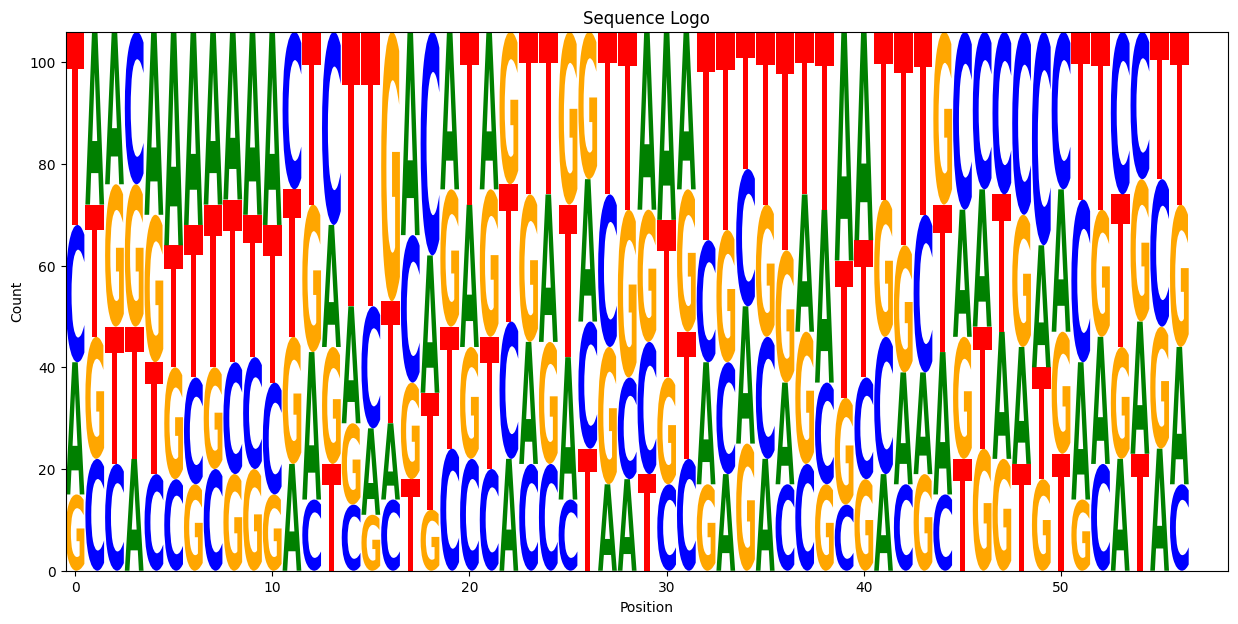

In [46]:
max_len = df['seq_length'].max()
sequences = [seq.ljust(max_len, '-') for seq in df['sequence']]
count_matrix = pd.DataFrame({
    'A': [sum(seq[i] == 'a' for seq in sequences) for i in range(max_len)],
    'C': [sum(seq[i] == 'c' for seq in sequences) for i in range(max_len)],
    'G': [sum(seq[i] == 'g' for seq in sequences) for i in range(max_len)],
    'T': [sum(seq[i] == 't' for seq in sequences) for i in range(max_len)]
})

logo = logomaker.Logo(count_matrix, color_scheme='classic',figsize=(15,7))
plt.title('Sequence Logo')
plt.xlabel('Position')
plt.ylabel('Count')
plt.show()

# Heatmap of Nucleotide Counts

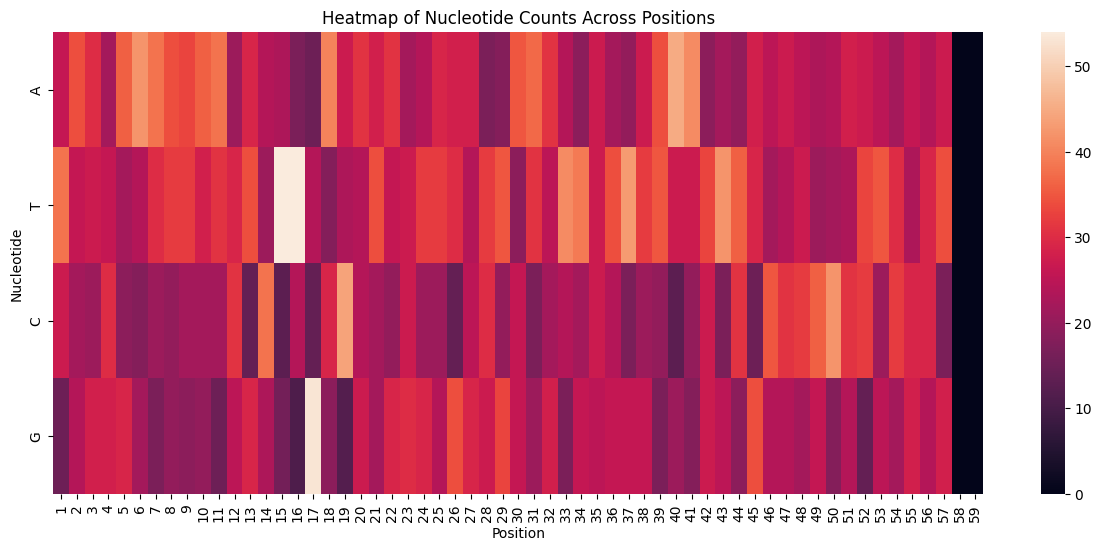

In [47]:
nucleotide_matrix = np.zeros((len(df), max_len, 4))
for i, seq in enumerate(df['sequence']):
    for j, nuc in enumerate(seq):
        if nuc == 'a':
            nucleotide_matrix[i, j, 0] = 1
        elif nuc == 't':
            nucleotide_matrix[i, j, 1] = 1
        elif nuc == 'c':
            nucleotide_matrix[i, j, 2] = 1
        elif nuc == 'g':
            nucleotide_matrix[i, j, 3] = 1
nucleotide_matrix_sum = nucleotide_matrix.sum(axis=0)
plt.figure(figsize=(15, 6))
sns.heatmap(nucleotide_matrix_sum.T, xticklabels=range(1, max_len+1), yticklabels=['A', 'T', 'C', 'G'])
plt.title('Heatmap of Nucleotide Counts Across Positions')
plt.xlabel('Position')
plt.ylabel('Nucleotide')
plt.show()

# Word Cloud of IDs

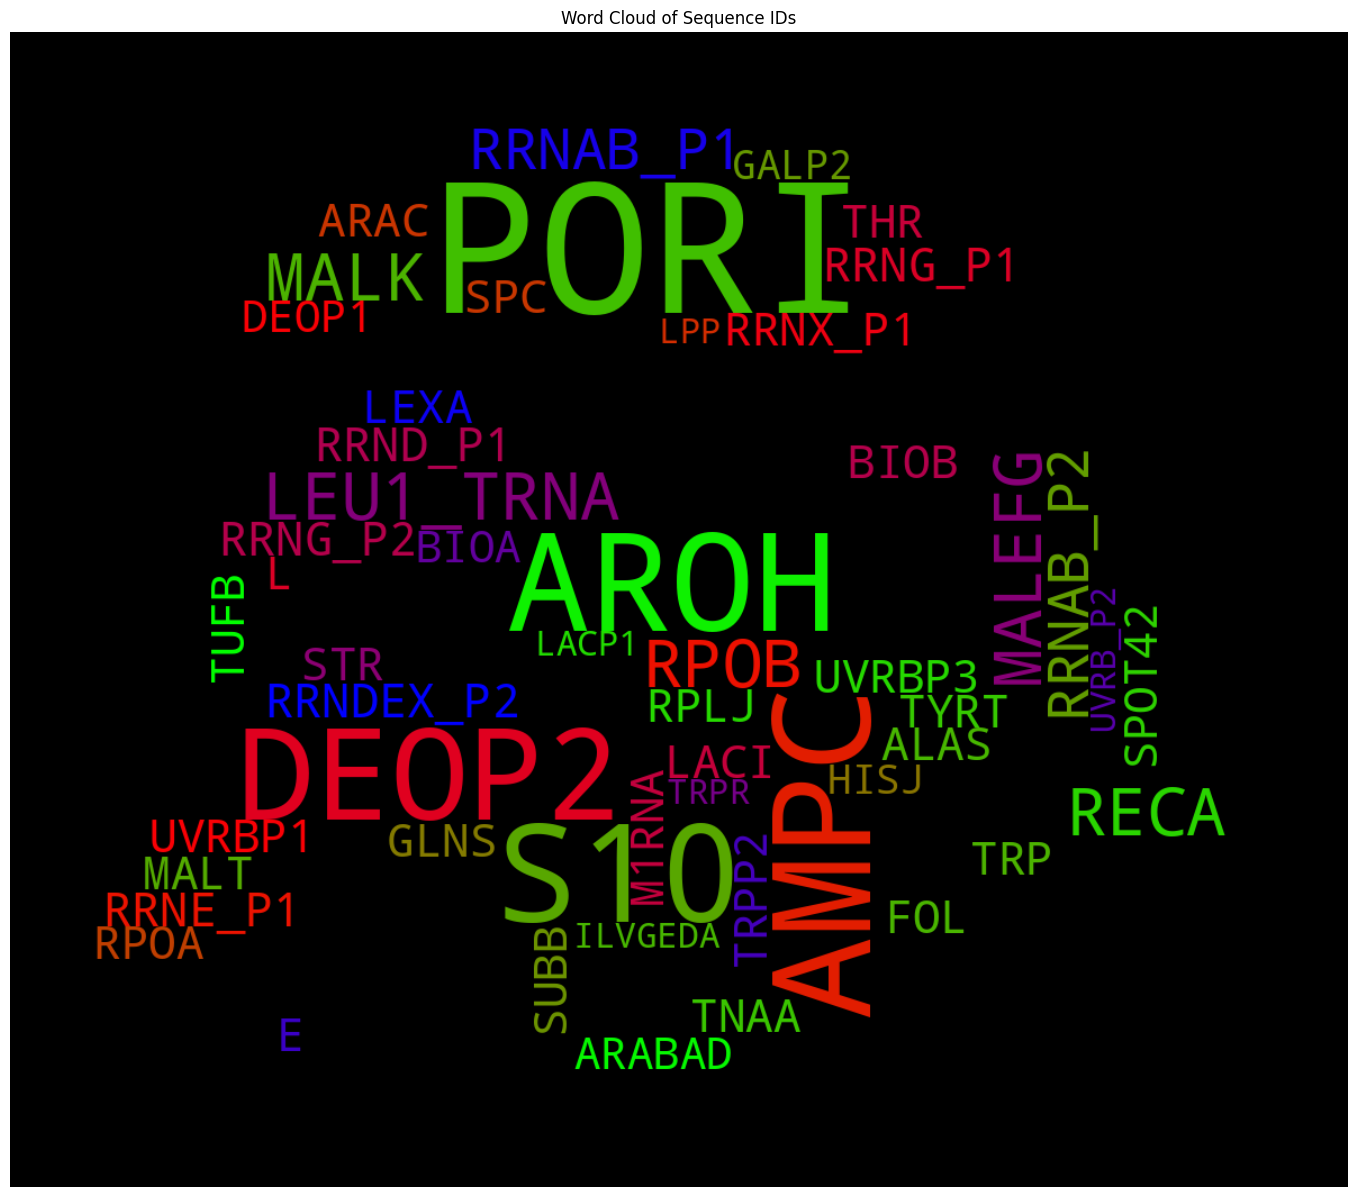

In [48]:
mask=np.array(Image.open("/kaggle/input/wordcloud-mask-collection/stormtrooper_mask.png"))
wordcloud = WordCloud(width=800, height=400, background_color='black',mask=mask,colormap="brg").generate(' '.join(df['id']))
plt.figure(figsize=(20, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Sequence IDs')
plt.show()

In [49]:
df.drop(columns=["gc_content","seq_length"],axis=1,inplace=True)

In [50]:
sequences = list(df['sequence'])
classes = list(df['class'])

# Create dictionary with character lists and appended class
dic = {}
for i, seq in enumerate(sequences):
    # Convert sequence to list of characters
    nucleotides = list(seq)
    # Append class
    nucleotides.append(classes[i])
    # Store in dictionary
    dic[i] = nucleotides

# Print the result for each index
for i in range(len(dic)):
    print(f"dic[{i}]: {dic[i]}")

dic[0]: ['t', 'a', 'c', 't', 'a', 'g', 'c', 'a', 'a', 't', 'a', 'c', 'g', 'c', 't', 't', 'g', 'c', 'g', 't', 't', 'c', 'g', 'g', 't', 'g', 'g', 't', 't', 'a', 'a', 'g', 't', 'a', 't', 'g', 't', 'a', 't', 'a', 'a', 't', 'g', 'c', 'g', 'c', 'g', 'g', 'g', 'c', 't', 't', 'g', 't', 'c', 'g', 't', '+']
dic[1]: ['t', 'g', 'c', 't', 'a', 't', 'c', 'c', 't', 'g', 'a', 'c', 'a', 'g', 't', 't', 'g', 't', 'c', 'a', 'c', 'g', 'c', 't', 'g', 'a', 't', 't', 'g', 'g', 't', 'g', 't', 'c', 'g', 't', 't', 'a', 'c', 'a', 'a', 't', 'c', 't', 'a', 'a', 'c', 'g', 'c', 'a', 't', 'c', 'g', 'c', 'c', 'a', 'a', '+']
dic[2]: ['g', 't', 'a', 'c', 't', 'a', 'g', 'a', 'g', 'a', 'a', 'c', 't', 'a', 'g', 't', 'g', 'c', 'a', 't', 't', 'a', 'g', 'c', 't', 't', 'a', 't', 't', 't', 't', 't', 't', 't', 'g', 't', 't', 'a', 't', 'c', 'a', 't', 'g', 'c', 't', 'a', 'a', 'c', 'c', 'a', 'c', 'c', 'c', 'g', 'g', 'c', 'g', '+']
dic[3]: ['a', 'a', 't', 't', 'g', 't', 'g', 'a', 't', 'g', 't', 'g', 't', 'a', 't', 'c', 'g', 'a', 'a',

In [51]:
df = pd.DataFrame(dic)
df=df.transpose()
df.rename(columns = {57:'Class'}, inplace = True)
df.replace({"+":1,"-":0},inplace=True)
df.head()

/tmp/ipykernel_280/3343837791.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({"+":1,"-":0},inplace=True)


,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,Class
0,t,a,c,t,a,g,c,a,a,t,...,g,c,t,t,g,t,c,g,t,1
1,t,g,c,t,a,t,c,c,t,g,...,c,a,t,c,g,c,c,a,a,1
2,g,t,a,c,t,a,g,a,g,a,...,c,a,c,c,c,g,g,c,g,1
3,a,a,t,t,g,t,g,a,t,g,...,a,a,c,a,a,a,c,t,c,1
4,t,c,g,a,t,a,a,t,t,a,...,c,c,g,t,g,g,t,a,g,1


In [52]:
X=df.drop(columns=["Class"],axis=1)
y=df["Class"]

In [53]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_encoded = encoder.fit_transform(X)
X_encoded=pd.DataFrame(X_encoded)
print(encoder.categories_)
print("###"*100)
X_encoded.head()

[array(['a', 'c', 'g', 't'], dtype=object), array(['a', 'c', 'g', 't'], dtype=object), array(['a', 'c', 'g', 't'], dtype=object), array(['a', 'c', 'g', 't'], dtype=object), array(['a', 'c', 'g', 't'], dtype=object), array(['a', 'c', 'g', 't'], dtype=object), array(['a', 'c', 'g', 't'], dtype=object), array(['a', 'c', 'g', 't'], dtype=object), array(['a', 'c', 'g', 't'], dtype=object), array(['a', 'c', 'g', 't'], dtype=object), array(['a', 'c', 'g', 't'], dtype=object), array(['a', 'c', 'g', 't'], dtype=object), array(['a', 'c', 'g', 't'], dtype=object), array(['a', 'c', 'g', 't'], dtype=object), array(['a', 'c', 'g', 't'], dtype=object), array(['a', 'c', 'g', 't'], dtype=object), array(['a', 'c', 'g', 't'], dtype=object), array(['a', 'c', 'g', 't'], dtype=object), array(['a', 'c', 'g', 't'], dtype=object), array(['a', 'c', 'g', 't'], dtype=object), array(['a', 'c', 'g', 't'], dtype=object), array(['a', 'c', 'g', 't'], dtype=object), array(['a', 'c', 'g', 't'], dtype=object), array(['a'

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,0,1,2,3,4,5,6,7,8,9,...,218,219,220,221,222,223,224,225,226,227
0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [54]:
file = open("onehotencoder.pkl", "wb")
pickle.dump(encoder, file)
file.close()

In [55]:
X_encoded.shape

(106, 228)

In [56]:
y.shape

(106,)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded,y,test_size=0.2,random_state=42,stratify=y)
print(f"Train shape: {X_train.shape}, {y_train.shape}")
print(f"Test shape: {X_test.shape}, {y_test.shape}")

Train shape: (84, 228), (84,)
Test shape: (22, 228), (22,)


In [58]:
model = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=42)
model.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(150, 100, 50), max_iter=300, random_state=42)

In [59]:
file = open("mlp_model.pkl", "wb")
pickle.dump(model, file)
file.close()

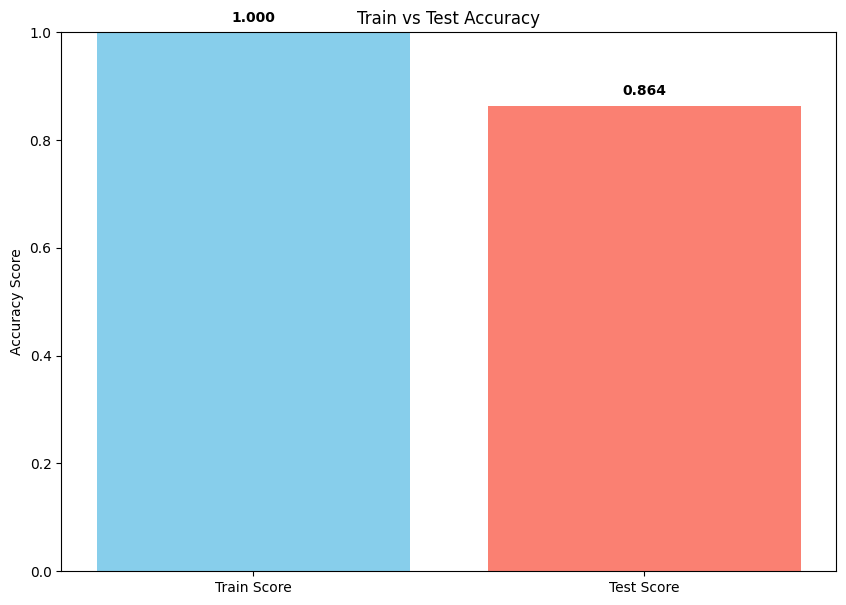

In [60]:
train_score=model.score(X_train,y_train)
test_score=model.score(X_test,y_test)
scores = [train_score, test_score]
labels = ['Train Score', 'Test Score']
plt.figure(figsize=(10,7))
plt.bar(labels, scores, color=['skyblue', 'salmon'])
plt.ylim(0, 1)
plt.ylabel('Accuracy Score')
plt.title('Train vs Test Accuracy')
for i, v in enumerate(scores):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center', fontweight='bold')
plt.show()

In [61]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.82      0.86        11
           1       0.83      0.91      0.87        11

    accuracy                           0.86        22
   macro avg       0.87      0.86      0.86        22
weighted avg       0.87      0.86      0.86        22



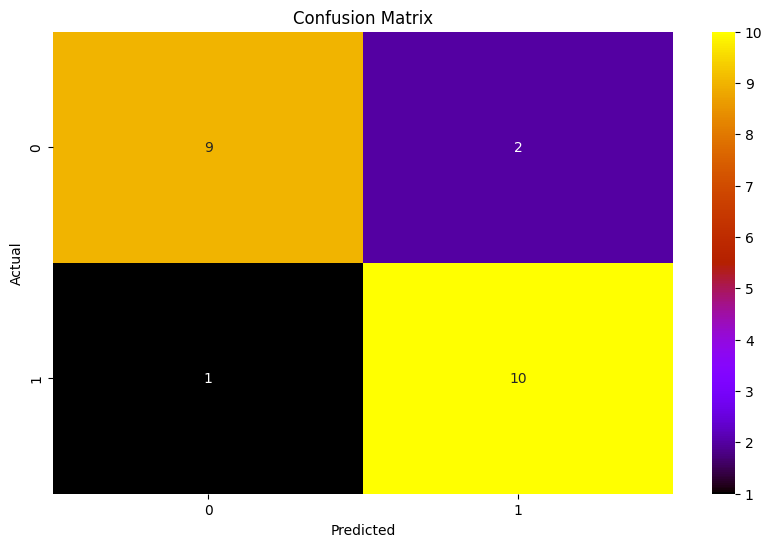

In [62]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='gnuplot', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

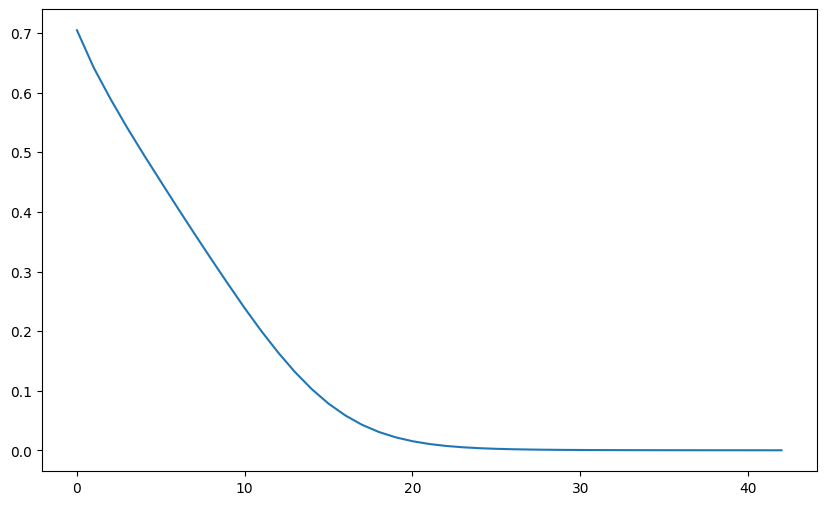

In [63]:
plt.figure(figsize=(10,6))
loss_values = model.loss_curve_
plt.plot(loss_values)
plt.show()

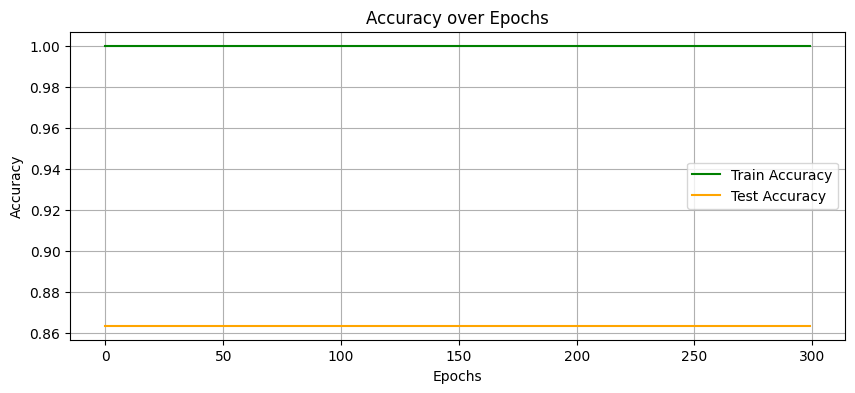

In [64]:
train_scores = []
test_scores = []



for i in range(300):  
  
    train_scores.append(model.score(X_train, y_train))
    test_scores.append(model.score(X_test, y_test))

plt.figure(figsize=(10, 4))
plt.plot(train_scores, label='Train Accuracy', color='green')
plt.plot(test_scores, label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.grid(True)
plt.legend()
plt.show()


In [65]:
test_genome="ttactagcaatacgcttgcgttcggtggttaagtatgtataatgcgcgggcttgtcg"
genome_list=list(test_genome)
test_df=pd.DataFrame(genome_list)
test_df=test_df.transpose()
pred=encoder.transform(test_df)
predict=model.predict(pred)
print(f"Model Prediction : {predict}")

Model Prediction : [1]


In [66]:
! pip freeze

absl-py==1.4.0
accelerate==1.5.2
aiofiles==22.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.11.18
aiosignal==1.3.2
aiosqlite==0.21.0
alabaster==1.0.0
albucore==0.0.23
albumentations==2.0.5
ale-py==0.10.2
alembic==1.15.2
altair==5.5.0
annotated-types==0.7.0
annoy==1.17.3
ansicolors==1.1.8
antlr4-python3-runtime==4.9.3
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
args==0.1.0
array_record==0.7.1
arrow==1.3.0
arviz==0.21.0
astropy==7.0.1
astropy-iers-data==0.2025.3.31.0.36.18
asttokens==3.0.0
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
bayesian-optimization==2.0.3
beartype==0.20.2
beautifulsoup4==4.13.3
betterproto==2.0.0b6
bigframes==1.42.0
bigquery-magics==0.9.0
biopython==1.85
bleach==6.2.0
blinker==1.9.0
blis==1.2.1
blobfile==3.0.0
blosc2==3.2.1
bokeh==3.6.3
Boruta==0.4.3
boto3==1.38.11
botocore==1.38.11
Bottleneck==1.4.2
-e git+https://github.com/SohierDane/BigQuery_Helper@8615a7f6c1663e7f2d48aa2b32c2dbcb600a44